In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>")) # makes the notebook fill the whole window

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from matplotlib import ticker
import datetime
import os
import re
import pandas as pd
import shutil
import pycubicspline
import smtplib, ssl
import time

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN

from mpl_toolkits.basemap import Basemap
import matplotlib.image as mpimg

from glmtools.io.glm import GLMDataset

import haversine

from squeemtools.math import FCM
from squeemtools.other import EmailDone
import BetterMap as BM
import storm_centered_coords as scc

import warnings
warnings.filterwarnings("ignore")

#Turn off interactive plotting for pyplot
plt.ioff()

C:\Users\bvano\Anaconda3\envs\glmval\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [2]:
data = xr.open_dataset('./Data/Hurricane_Laura.nc')
laura = data.to_dataframe()
del data

laura_center = pd.read_csv("./ATL_20_13_Laura_Reduced_Trackfile_Spline.csv")
laura_center['Date'] = laura_center['Date'].apply(pd.to_datetime)

dates = [pd.to_datetime(date) for date in laura_center['Date'].values]

points = []
total_data = []
for index,date in enumerate(dates):
    subset = laura[(laura['group_time_offset'] >= date) & (laura['group_time_offset'] < date + datetime.timedelta(minutes=10))]
    center_long, center_lat = laura_center[laura_center['Date'] == date][["Long","Lat"]].values.flatten()

    data = subset[(subset['group_lat'] < center_lat + 5) & (subset['group_lat'] > center_lat - 5) & (subset['group_lon'] < center_long + 5) & (subset['group_lon'] > center_long - 5)]
    if(len(data) != 0):
        total_data.append(data['group_id'].values)
#     for point in subset.values:
#         pt = point[-2:]
#         dist = haversine.haversine(pt,(center_lat,center_long))
#         if dist <= 500:
#             points.append(point)
    print(f"{(index + 1) / len(dates) * 100 : .2f}",end='\r')
    
ids = np.concatenate(np.array(total_data).flatten())
data = laura[laura['group_id'].isin(ids)].to_xarray()
data.to_netcdf('./Processed_Laura.nc')

In [15]:
data = xr.open_dataset('./Hurricane_Dorian.nc')
dorian = data.to_dataframe()
del data

dorian_center = pd.read_csv('./ATL_19_5_Dorian_Cubic_Spline_Trackfile.csv')
dorian_center['Date'] = dorian_center['Date'].apply(pd.to_datetime)

dates = [pd.to_datetime(date) for date in dorian_center['Date'].values]

In [27]:
points = []
total_data = []
for index,date in enumerate(dates):
    subset = dorian[(dorian['group_time_offset'] >= date) & (dorian['group_time_offset'] < date + datetime.timedelta(minutes=10))]
    center_long, center_lat = dorian_center[dorian_center['Date'] == date][["Long","Lat"]].values.flatten()

    data = subset[(subset['group_lat'] < center_lat + 5) & (subset['group_lat'] > center_lat - 5) & (subset['group_lon'] < center_long + 5) & (subset['group_lon'] > center_long - 5)]
    if(len(data) != 0):
        total_data.append(data['group_id'].values)
#     for point in subset.values:
#         pt = point[-2:]
#         dist = haversine.haversine(pt,(center_lat,center_long))
#         if dist <= 500:
#             points.append(point)
    break
    print(date,end='\r')

In [40]:
ids = np.concatenate(np.array(total_data).flatten())

data = dorian[dorian['group_id'].isin(ids)].to_xarray()

data.to_netcdf('./Processed_Dorian.nc')

In [240]:
dorian_processed = xr.open_dataset('./Processed_Dorian.nc')
dp = dorian_processed.to_dataframe()

dorian_center = pd.read_csv('./ATL_19_5_Dorian_Cubic_Spline_Trackfile.csv')
dorian_center['Date'] = dorian_center['Date'].apply(pd.to_datetime)
dates = [pd.to_datetime(date) for date in dorian_center['Date'].values]

In [285]:
# Map boundaries
buffer = 7.5
shp_file = "./ne_10m_coastline/ne_10m_coastline"
cmap = 'gist_ncar'
centers = pd.DataFrame([(np.random.uniform(-180,180),np.random.uniform(-90,90)) for _ in range(50)])

for index,date in enumerate(dates):
    starttime = time.perf_counter()
    subset = dp[(dp['group_time_offset'] >= date) & (dp['group_time_offset'] < date + datetime.timedelta(minutes=10))].copy()
    center = dorian_center[dorian_center['Date'] == date]
    
    if len(subset) != 0:
        dbscan = DBSCAN(eps=.12,min_samples=2)
        subset['labels'] = dbscan.fit_predict(subset[['group_lon','group_lat']])
        subset['labels'] = subset.apply(relabel,axis=1,past_centers=centers.values)
        centers = subset.groupby('labels').mean()[['group_lon','group_lat']]
    else:
        centers = pd.DataFrame([(np.random.uniform(-180,180),np.random.uniform(-90,90)) for _ in range(50)])
    
    edges = (center['Long'].values[0] - buffer, center['Long'].values[0] + buffer, center['Lat'].values[0] - buffer, center['Lat'].values[0] + buffer)
    
    xlim = np.append(np.arange(edges[0],edges[1],step=2.5),edges[1])
    ylim = np.append(np.arange(edges[2],edges[3],step=2.5),edges[3])
    
    fig, ax = plt.subplots(figsize=(30,15))
    m = Basemap()
    m.readshapefile(shp_file, 'world',linewidth=1)
    
    if len(subset) != 0:
        #plt.scatter(subset['group_lon'],subset['group_lat'],c=subset['labels'],cmap=cmap)
        m.scatter(subset['group_lon'],subset['group_lat'],c=subset['labels'],cmap=cmap)
    #m.plot(subset['group_lon'],subset['group_lat'],linestyle='none', marker="o", markersize=5, alpha=1, c="yellow", markeredgecolor="black", markeredgewidth=1,zorder=5)
    m.plot(center['Long'],center['Lat'],linestyle='none', marker="o", markersize=10, alpha=1, c="red", markeredgecolor="black", markeredgewidth=1,zorder=5)
    
    plt.title(f"Hurricane Dorian : {date}")
    ax.set_xticks(xlim)
    ax.set_yticks(ylim)
    ax.set_xlim(edges[0],edges[1])
    ax.set_ylim(edges[2],edges[3])
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
    
    
    plt.savefig(f"./Dorian_Images_2/{index}",bbox_inches='tight',pad_inches=.4) 
    plt.close('all')
    
    taken = time.perf_counter() - starttime
    print(f"Percent Done: {(index + 1) / len(dates) * 100 : .2f}%\tTime taken: {taken : .2f} seconds\tEst time remaining: {datetime.timedelta(seconds=(len(dates) - (index + 1)) * taken)} {len(subset)}",end='\r')

KeyboardInterrupt: 

In [15]:
buffer = 2.5
num_cents = 12
prevCents = pd.DataFrame(np.nan,index=[x for x in range(num_cents)],columns=['Long','Lat'])
number_images = len(dates)

for index,date in enumerate(dates):
    subset = dp[(dp['group_time_offset'] >= date) & (dp['group_time_offset'] < date + datetime.timedelta(minutes=10))].copy()
    center = dorian_center[dorian_center['Date'] == date]

    edges = (center['Long'].values[0] - 5, center['Long'].values[0] + 5, center['Lat'].values[0] - 5, center['Lat'].values[0] + 5)

    fig = plt.figure(figsize=(30,15))
    m = BM.CreateMapBackground(edges,buffer)
    
    #Plot ticks for lat/long
    plt.xticks([round(x,2) for x in np.arange(edges[0],edges[1],step=5)])
    plt.yticks([round(x,2) for x in np.arange(edges[2],edges[3],step=5)])
    #Title the map 2017:month:day::hour:minute
    plt.title(f"{date}")
    
    if(len(subset) != 0):
        if prevCents.isnull().values.any() or prevCents.duplicated().values.any():
            fcm = FCM.FCM(subset[['group_lon','group_lat']],num_cents,2,maxiter=10,genCentroids=True)
        else:
            fcm = FCM.FCM(subset[['group_lon','group_lat']],num_cents,2,maxiter=10,genCentroids=prevCents)

        cents = fcm.fit()
        prevCents = cents.copy()
        subset['C'] = fcm.classify()

        # Plot all of the centroids
        if not cents.isnull().values.any():  m.scatter(cents['group_lon'],cents['group_lat'],marker='*',c=cents.index/num_cents,s=90,cmap='Paired',edgecolors='black',linewidths=1,zorder=4)
        # Plot all of the points
        if not subset.isnull().values.any():  m.scatter(subset['group_lon'],subset['group_lat'],c=subset['C']/num_cents,cmap='Paired',s=45,edgecolors='black',linewidths=1,zorder=3)

    m.plot(center['Long'], center['Lat'], linestyle='none', marker="o", markersize=20, alpha=1, c="yellow", markeredgecolor="black", markeredgewidth=1,zorder=2)

    subset = pd.DataFrame(None)
    plt.savefig(f"./Dorian_Images/{index}",bbox_inches='tight')
    plt.close(fig)
    
    print(f"{(index + 1) / number_images * 100 : .2f}%",end='\r')

KeyboardInterrupt: 

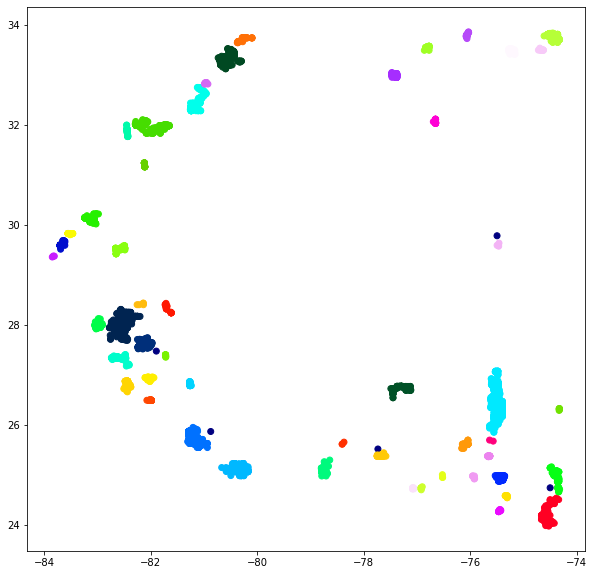

In [269]:
date = pd.to_datetime("2019-09-01 20:00:00")
subset = dp[(dp['group_time_offset'] >= date) & (dp['group_time_offset'] < date + datetime.timedelta(minutes=10))].copy()
dbscan = DBSCAN(eps=.12,min_samples=2)
subset['labels'] = dbscan.fit_predict(subset[['group_lon','group_lat']])
centers = subset.groupby('labels').mean()[['group_lon','group_lat']]

cmap = 'gist_ncar'
#cmap = 'nipy_spectral'
fig = plt.figure(figsize=(10,10))
plt.scatter(subset['group_lon'],subset['group_lat'],c=subset['labels'],cmap=cmap)
plt.show()

In [283]:
def find_nearest(array, value):
    array = np.asarray(array)
    closest = min(array, key=lambda x: np.linalg.norm(x - value))
    return closest

def relabel(x,past_centers):
    if x['labels'] != -1 and x['labels'] < len(past_centers) - 1:
        new_label = find_nearest(past_centers,x[['group_lon','group_lat']]).tolist()
        return past_centers.tolist().index(new_label)
    else:
        return x['labels']

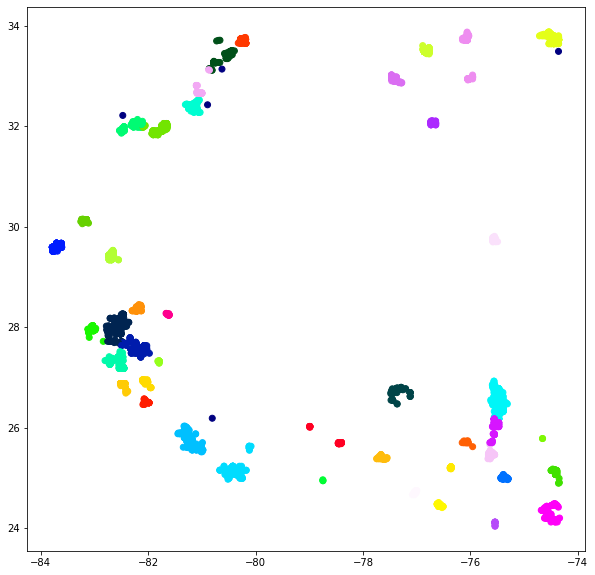

Wall time: 1min 13s


In [275]:
%%time
date = pd.to_datetime("2019-09-01 20:10:00")
subset = dp[(dp['group_time_offset'] >= date) & (dp['group_time_offset'] < date + datetime.timedelta(minutes=10))].copy()
dbscan = DBSCAN(eps=.12,min_samples=2)
subset['labels'] = dbscan.fit_predict(subset[['group_lon','group_lat']])
if centers is not None:
    subset['labels'] = subset.apply(relabel,axis=1,past_centers=centers.values)
centers = subset.groupby('labels').mean()[['group_lon','group_lat']]

cmap = 'gist_ncar'
fig = plt.figure(figsize=(10,10))
plt.scatter(subset['group_lon'],subset['group_lat'],c=subset['labels'],cmap=cmap)
plt.show()

In [276]:
display(subset)

,group_energy,group_area,group_id,group_time_offset,group_lat,group_lon,labels
number_of_groups,,,,,,,
768,0.000006,132.763611,912493578,2019-09-01 20:10:01.105135440,26.771423,-77.337547,2
769,0.000003,66.381805,912493605,2019-09-01 20:10:01.132983207,26.771385,-77.373520,2
770,0.000006,132.763611,912493660,2019-09-01 20:10:01.184482574,26.771357,-77.330223,2
771,0.000003,66.381805,912493678,2019-09-01 20:10:01.206608295,26.771469,-77.373421,2
772,0.000003,66.381805,912493701,2019-09-01 20:10:01.242085456,26.771507,-77.373474,2
...,...,...,...,...,...,...,...
7115,0.000011,133.831833,912787480,2019-09-01 20:19:55.035480499,26.795233,-81.949066,24
7116,0.000011,133.831833,912787483,2019-09-01 20:19:55.037769317,26.795238,-81.950760,24
7117,0.000006,133.831833,912787487,2019-09-01 20:19:55.043491363,26.795353,-81.962952,24


In [264]:
[3 for x in range(3)]

[3, 3, 3]